In [49]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from LinerarClassification import LinearClassifier
import matplotlib.pyplot as plt

In [50]:
data = pd.read_csv('breast-cancer.csv')
le = preprocessing.LabelEncoder()
for column_name in data.columns:
    data[column_name]=le.fit_transform(data[column_name])
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,41,1,370,1,455,452,444,531,521,526,...,425,41,497,516,358,516,520,483,485,506
1,42,1,426,186,486,513,120,215,321,396,...,419,199,465,511,158,210,278,401,222,375
2,488,1,406,324,478,487,403,459,478,516,...,399,261,455,491,287,464,438,468,445,361
3,489,1,98,297,164,95,471,533,507,493,...,215,298,281,194,408,524,511,479,499,533
4,490,1,418,60,493,506,332,414,480,492,...,381,28,453,470,239,245,415,363,81,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,381,1,438,370,503,522,410,364,509,522,...,426,293,480,518,263,255,423,453,21,133
565,382,1,413,463,483,499,295,312,415,483,...,401,494,459,493,116,218,350,364,152,63
566,383,1,340,458,410,421,115,308,329,335,...,328,460,390,413,106,371,366,317,40,244
567,384,1,429,467,500,501,442,530,530,531,...,431,500,497,502,367,525,534,482,472,514


In [51]:
def plot_margins(margins):
    plt.figure(figsize=(8, 4))
    plt.plot(margins, linestyle='-', color='black')
    plt.axhline(0, color='black')
    plt.ylabel("Отступ", fontsize=10)
    plt.fill_between(range(len(margins)), margins, 0, where=(margins > 0.3), color='green', label='Надежные (|M| > 0.3)')
    plt.fill_between(range(len(margins)), margins, 0, where=np.bitwise_and(margins >= -0.3, margins <= 0.3), color='yellow', 
                     label='Пограничные (-0.3 <= |M| <= 0.3)')
    plt.fill_between(range(len(margins)), margins, 0, where=(margins < -0.3), color='red', label='Шумовые (|M| < -0.3)')
    plt.legend()
    plt.show()

(398, 30) (171, 30) (398,) (171,)


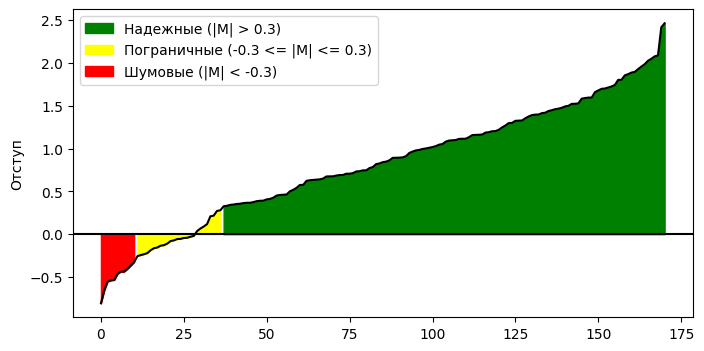

Time (corr init, momentum): 0.2848484516143799


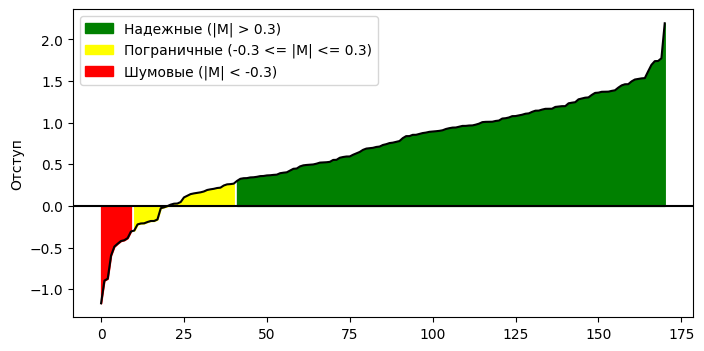

Time (multi init, momentum): 0.2810091972351074


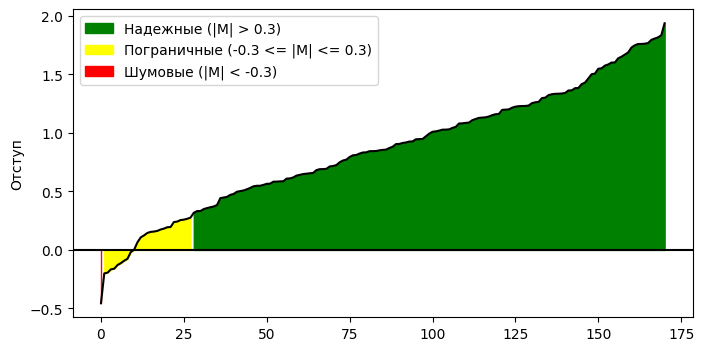

Time (random init, margin method): 0.5811629295349121
Accuracy (corr init, momentum): 0.8304093567251462
Accuracy (multi init, momentum): 0.8771929824561403
Accuracy (multi init, margin method): 0.9415204678362573
Accuracy (SGDClassifier, sklearn): 0.9707602339181286
Time (SGDClassifier, sklearn): 0.003000497817993164
Best of our methods: 0.9415204678362573
Compare to sklearn: 0.9707602339181286


In [52]:
X = data.drop(['diagnosis', 'id'], axis=1)
y = data['diagnosis']
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf_corr = LinearClassifier(
    alpha=0.1,
    n_epochs=50,
    method='fast_gd',
    initialization='correlation',
    n_starts=5
)
t1 = time.time()
clf_corr.fit(X_train, y_train)
t2 = time.time()
acc_corr = np.mean(clf_corr.predict(X_test) == y_test)
margins = np.sort(clf_corr.compute_margin(X_test, y_test))
plot_margins(margins)

print("Time (corr init, momentum):", t2 - t1)

clf_multi = LinearClassifier(
    alpha=0.1,
    n_epochs=50,
    method='fast_gd',
    initialization='multistart',
    n_starts=5
)
t1 = time.time()
clf_multi.fit(X_train, y_train)
t2 = time.time()
acc_multi = np.mean(clf_multi.predict(X_test) == y_test)
margins = np.sort(clf_multi.compute_margin(X_test, y_test))
plot_margins(margins)

print("Time (multi init, momentum):", t2 - t1)

clf_margin = LinearClassifier(
    alpha=0.1,
    n_epochs=50,
    method='margin_prob',
    initialization='multistart',
    n_starts=5
)
t1 = time.time()
clf_margin.fit(X_train, y_train)
t2 = time.time()
acc_margin = np.mean(clf_margin.predict(X_test) == y_test)
margins = np.sort(clf_margin.compute_margin(X_test, y_test))
plot_margins(margins)

print("Time (random init, margin method):", t2 - t1)

print("Accuracy (corr init, momentum):", acc_corr)
print("Accuracy (multi init, momentum):", acc_multi)
print("Accuracy (multi init, margin method):", acc_margin)

sgd_sklearn = SGDClassifier(
    loss='squared_error',
    alpha=0.1,       
    learning_rate='constant',
    eta0=0.01,       
    penalty='l2',
    max_iter=1000,
    random_state=42
)
t1 = time.time()
sgd_sklearn.fit(X_train, y_train)
t2 = time.time()
acc_sklearn = np.mean(sgd_sklearn.predict(X_test) == y_test)
print("Accuracy (SGDClassifier, sklearn):", acc_sklearn)
print("Time (SGDClassifier, sklearn):", t2 - t1)

best_ours = max(acc_corr, acc_multi, acc_margin)
print("Best of our methods:", best_ours)
print("Compare to sklearn:", acc_sklearn)